### Notebook #6

## Table of Contents
1) <a href="#word" id="top">Word2Vec</a>
2) <a href="#vec">Word2Vec_V2</a>
3) <a href="#model">MLPClassifier</a>

## Intro

In this notebook we will be training both a `Word2Vec` model and an `MLPClassifier` neural network. `Word2Vec` creates word embeddings that use a sliding window to predict the words around it in the form of `CBOW` and `SkipGrams`. Put another way, it is aware of its surroundings, its **context**, which is exactly what we need. Aside from that, it creates unique vectors for every word which can be used to make mathematical operations between words, testing their similarity. `Word2Vec` can come pre-trained or trained from scratch. We will be doing the latter as a start. `MLPClassifier` is a solid baseline `NN` model which will allow us to quickly deploy a neural net.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import regex as re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')


from gensim.models import Word2Vec


import warnings 
warnings.filterwarnings(action = 'ignore')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# reading in csv and checking head
reddit = pd.read_csv('sample_comments.csv', index_col=0)

reddit.head()

,label,comment
139484,0,Nope.
638093,0,Donde esta la biblioteca?
662570,0,I feel bad for the mummy... not even the minio...
652534,1,"The Pirate Bay, of course!"
411846,1,That's exactly how multiple photographers ende...


We will be using a slightly modified tokenizer function that will:
1) Keep stop words
2) Keep stems
3) Accomodate the passing of a series

In [4]:
# custom tokenizer function

def tokenizer(series):
    
    corpus = series.values
    tokens = []
    
    for document in corpus:
        #removing punctuation
        for punc in string.punctuation:
            document = document.replace(punc, '')
        # removing numbers and splitting sentences    
        document = re.sub("\d+", "", document).lower()
        tokens.append(document.split(' '))
        
    
        

    return tokens

In [5]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [6]:
# testing tokenizer function
tokenizer(X[:2])

[['nope'], ['donde', 'esta', 'la', 'biblioteca']]

Our tokenizer function works, so we will pass through our `X` and set the resulting list to a variable.

In [7]:
# tokenizing our comments
tokenized_data = tokenizer(X)

## <a href="#top" id="word">Word2Vec</a>

    We will be training our tokens on the Word2Vec model. It will use a window size of 5 to predict surrounding words and will create embeddings that we can explore and eventually fit to a model.

In [8]:
# instantiating word2vec model that will be trained on our dataset
model = Word2Vec(tokenized_data, window=5, min_count=1, workers=4)
model.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)

(10358800, 13178775)

Now that we have our vectors, we can do a brief EDA on key words of interest and check their similarities to other words in the dataset.

In [9]:
model.most_similar('sarcastic')

[('facetious', 0.8120466470718384),
 ('detained', 0.7430076599121094),
 ('pedantic', 0.7109238505363464),
 ('griefed', 0.7034671306610107),
 ('bitbybit', 0.6912793517112732),
 ('joking', 0.6885679364204407),
 ('mocked', 0.6774377226829529),
 ('aggressor', 0.6767247915267944),
 ('johny', 0.6701516509056091),
 ('irishamerican', 0.6680042147636414)]

In [10]:
model.most_similar('sarcasm')

[('comment', 0.6513453125953674),
 ('tag', 0.6342936754226685),
 ('username', 0.6152840256690979),
 ('nsfw', 0.6076558232307434),
 ('post', 0.5954855680465698),
 ('text', 0.5945448279380798),
 ('satire', 0.5909705758094788),
 ('buzzfeed', 0.583030104637146),
 ('op', 0.5818008780479431),
 ('typo', 0.5724892616271973)]

In [11]:
model.most_similar('satire')

[('statewide', 0.7574028372764587),
 ('staged', 0.7455390691757202),
 ('unacceptable', 0.7336013317108154),
 ('incorrect', 0.7258432507514954),
 ('mew', 0.7256834506988525),
 ('factually', 0.7224603891372681),
 ('cringyyyyy', 0.7190381288528442),
 ('godmann', 0.7125478982925415),
 ('ruuuuuiiined', 0.7117441296577454),
 ('censorship', 0.7084832787513733)]

In [12]:
model.most_similar(positive=['joke', 'sarcastic'], topn=5)

[('joking', 0.6859943270683289),
 ('creepy', 0.631734311580658),
 ('johny', 0.6236442923545837),
 ('facetious', 0.6166537404060364),
 ('rude', 0.6158333420753479)]

**In our initial EDA we found that the `politics` subreddit was one of the most sarcastic. That is the justification for this next query.**

In [13]:
model.most_similar(positive=['politics', 'sarcasm'])

[('gamergate', 0.6453166007995605),
 ('islam', 0.6435695886611938),
 ('statements', 0.6378083229064941),
 ('bigotry', 0.6366938352584839),
 ('nature', 0.6134522557258606),
 ('facts', 0.6132872104644775),
 ('science', 0.6130746006965637),
 ('nuance', 0.6064255237579346),
 ('opinions', 0.6059615015983582),
 ('context', 0.600816547870636)]

    These test queries have led to mixed results. Some words are accurately similar to the target word, some are not, but there is definitely a concerning amount of nonsense words like "kmfdm", "kayfabe" "matante". For now we will continue to query further.

We will now move on to side-by-side comparisons of words that in theory should be predictive of sarcasm (or not).

In [14]:
sarcastic = model.most_similar(positive=['sarcastic'])
genuine = model.most_similar(positive=['genuine'])

pd.DataFrame(
        data={
            "sarcastic": [word for word, sim in sarcastic], 
            "genuine": [word for word, sim in genuine]
        }
)

,sarcastic,genuine
0,facetious,multimedia
1,detained,phir
2,pedantic,shrodingers
3,griefed,detected
4,bitbybit,chloe
5,joking,nooooooooooooooooooooooooo
6,mocked,methinks
7,aggressor,khaye
8,johny,etikas
9,irishamerican,borrachos


Just as in the test results above, this table holds both words that do make sense and are related to the target, but also a good amount of nonsense words that one can only assume are usernames.

In [15]:
misleading = model.most_similar(positive=['misleading'])
honest = model.most_similar(positive=['honest'])

pd.DataFrame(
        data={
            "misleading": [word for word, sim in misleading], 
            "honest": [word for word, sim in honest]
        }
)

,misleading,honest
0,flawed,lowerbudget
1,informative,fair
2,clickbaity,grateful
3,clickbait,pitied
4,ibuki,qualified
5,inaccurate,polite
6,incorrect,paranoid
7,nfb,thankful
8,editorialized,therell
9,jeor,attracted


More of the same in the result of this query, though I would say these words are more encouraging. There are some very appropriate matches:

**Misleading**
- clickbait
- editorialized
- sensationalized
- unintentional
- blatent

**Honest**
- fair
- thankful
- grateful
-  --> though this one: "rude" is an outlier. A negative sentiment word, though not quite an antonym, laying in the midst of a bunch of positive sentiment words

-------------------------------------------------------------------------------------------------------------------------------------------------------

Below is a list of 10 words pulled from the top (and bottom) `Logistic Regression` sarcasm predictors list. The first 5 words were among the top predictors of sarcasm and the last 5 were among the bottom predictors. We will plot these out by their word embedding vectors transformed into two dimensions through `PCA`. This is an effort to see if we can see any clear clusters and if their placements are consistent with the logreg predictions. 

In [16]:
words = ['duh', 'scrub', 'obvious', 'shitlord', 'forgot', 'imo', 'although', 'honestly', 'mostly', 'unfortunate']

In [17]:
sarcasm_test = []

# appending word vectors to list
for word in words:
    sarcasm_test.append(model[word])

In [18]:
from sklearn.decomposition import PCA

# instantiating pca to transfrom vectors into 2 dimensional representations for plotting
pca = PCA(n_components=2)

top_words = pca.fit_transform(sarcasm_test)

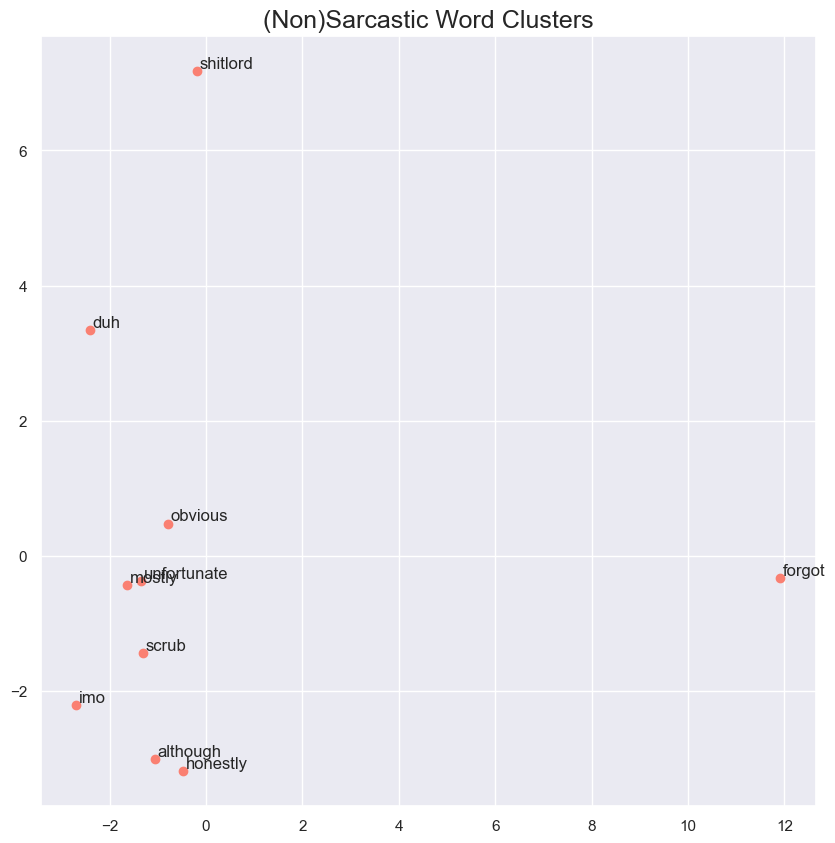

In [50]:
# plotting word vectors
plt.figure(figsize=(10,10))
plt.scatter(top_words[:,0], top_words[:,1], color ='salmon')
plt.title('(Non)Sarcastic Word Clusters', fontsize=18)
# annotating points
for i, word in enumerate(words):
    plt.annotate(word, xy=(top_words[i,0], top_words[i,1]), xytext=(2,2), textcoords='offset points')

plt.show()

In [20]:
def sentence(document):
    size = model.vector_size
    word_vec_document = np.zeros(size)
    count = 1
    
    for word in document:
        if word in model:
            count +=1
            word_vec_document += model[word]
    
    word_vec_document = word_vec_document / count
    
    return word_vec_document

In [21]:
# test sentences to run through sentence function
test_document = 'I love my wife. She is so beautiful.'
new_test = 'call me again tomorrow, so good to see you'

In [22]:
# testing sentence function
sentence(test_document)

array([ 0.0486307 ,  0.31501142,  0.12438124, -0.25027588, -0.63076075,
        0.90123444, -0.81810526,  0.7536797 ,  0.79527327, -1.21523213,
        0.81173154, -0.55702757, -0.15995806,  0.08755084,  0.12678383,
       -0.07936878,  0.2989074 ,  1.04797833,  0.63390049,  0.56088448,
        0.78662658,  0.19472906,  1.18038011, -0.85974307,  0.01885604,
        0.8681635 , -0.02071134,  0.31971104,  0.85426847,  0.55106933,
        0.52113873, -0.38818858, -1.14383782, -0.22524809,  0.30255553,
       -1.01912679, -0.62799309,  0.0968776 , -0.82988353, -0.02337664,
        0.78681783, -1.05688449,  0.05249448, -0.15165759, -0.44582234,
        0.1642979 , -0.43705779, -0.64628556,  0.095833  , -0.45797059,
        2.084663  ,  0.61501999,  0.19110555,  1.06487317, -0.25077253,
       -0.05404026, -0.61250427,  0.05809023, -1.02917394, -0.04873803,
        0.35889943, -0.34250882,  0.59924767,  0.29980468,  0.09940411,
        0.69899657,  0.35316288,  0.47926925,  0.08732865,  0.42

In [23]:
# setting new_test to temporary variable to check vector length
variable = sentence(new_test)
print(len(variable))

100


Having confirmed that our `sentence` function works, we can run our tokenized data through the function to create document vectors - but not before we optimize our tokens and vectors by improving our `Word2Vec` model.

## <a href="#top" id="vec">Word2Vec_V2</a>

Here we have a new and improved `Word2Vec` model, where we added a couple of hyperparameters in `size` and `max_vocab_size`.
- `size` being vector size, set to 300 -> leads to more precision
- `max_vocab_size` limits our vocabulary to 10,000 words, which should help filter our all of the nonsense words and usernames we encountered earlier.

In [31]:
# reinstantiating more precise word2vec 
model = Word2Vec(tokenized_data, window=5, min_count=1, workers=4, size=300, max_vocab_size=10000 )
model.train(tokenized_data, total_examples=model.corpus_count, epochs=model.epochs)

(8701532, 13178775)

    Below we will run a few similarity tests with our new embeddings to see if the results are more true to life and thereby (potentially) more predictive.

In [40]:
lie = model.most_similar(positive=['lie'])
truth = model.most_similar(positive=['truth'])

pd.DataFrame(
        data={
            "lie": [word for word, sim in lie], 
            "truth": [word for word, sim in truth]
        }
)

,lie,truth
0,talk,bible
1,complain,nsa
2,forget,cnn
3,trust,media
4,offend,us
5,listen,victim
6,criticize,msm
7,worry,patriarchy
8,care,internet
9,say,circlejerk


These results look a lot better. We don't have any usernames or nonsense words as we set a `max_vocab_size` to filter out the less common outlier words.

In [41]:
sarcastic = model.most_similar(positive=['sarcastic'])
honest = model.most_similar(positive=['honest'])

pd.DataFrame(
        data={
            "sarcastic": [word for word, sim in sarcastic], 
            "honest": [word for word, sim in honest]
        }
)

,sarcastic,honest
0,facetious,fair
1,joking,rude
2,downvoted,prepared
3,deansafbi,aggressive
4,rude,effective
5,planetarium,entertaining
6,serious,mature
7,aggressive,intelligent
8,optimistic,offensive
9,raped,forced


    Although these results are exclusively real words, and we do have a good amount of sensible matches, there is a concerning amount of antonyms that would be present in similar contexts, but have opposite meanings. These antonyms could mislead our model into predicting sarcasm from the word "serious" or "optimistic", which will surely not lead to accurate results.

In [43]:
serious = model.most_similar(positive=['serious'])
joking = model.most_similar(positive=['joking'])

pd.DataFrame(
        data={
            "serious": [word for word, sim in serious], 
            "joking": [word for word, sim in joking]
        }
)

,serious,joking
0,valid,forgetting
1,sarcastic,jealous
2,aggressive,thinking
3,positive,talking
4,relevant,worried
5,useful,sayin
6,irrelevant,crying
7,dumb,sarcastic
8,friendly,delusional
9,negative,implying


And finally, let us test out two of the words that our logreg model used to predict Non Sarcasm and see if these two words garner similar results to one another.

In [44]:
unfortunately = model.most_similar(positive=['unfortunately'])
honestly = model.most_similar(positive=['honestly'])

pd.DataFrame(
        data={
            "unfortunately": [word for word, sim in unfortunately], 
            "honestly": [word for word, sim in honestly]
        }
)

,unfortunately,honestly
0,certainly,tbh
1,sadly,dunno
2,however,disappointed
3,necessarily,personally
4,atleast,actually
5,but,although
6,exclusive,but
7,generally,sadly
8,guarantee,i
9,affect,kinda


Though these two words do not have any exact matches, one can get an overall sense of similarity between the two results.

--------------------------------------------------------------------------------------------------------------------------------------------------------

Now that we have our new and improved model, we may re-instantiate our X and perform and `train/test split` in preparation for modeling.

In [33]:
# setting vectors to variable
document_vectors = [sentence(doc) for doc in tokenized_data]

In [34]:
# verifying shape
document_vectors[0].shape

(300,)

In [35]:
# instantiating new X
X = document_vectors

In [36]:
from sklearn.model_selection import train_test_split
# initial split into rem and test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
# secondary split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [38]:
# verifying length of train
len(X_train)

142131

In [45]:
# verification of amount of vectors
len(X_train[0])

300

## <a href="#top" id="model">MLPClassifier</a>

Using `MLPClassifier` allows us to quickly implement a baseline neural network that has most of its defaults set to the most commonly used, industry standard values.

In [46]:
from sklearn.neural_network import MLPClassifier

In [47]:
neural_network = MLPClassifier(verbose=True, max_iter=50, random_state=42)

In [48]:
neural_network.fit(X_train, y_train)

Iteration 1, loss = 0.61989066
Iteration 2, loss = 0.59771830
Iteration 3, loss = 0.58921956
Iteration 4, loss = 0.58279922
Iteration 5, loss = 0.57729274
Iteration 6, loss = 0.57334721
Iteration 7, loss = 0.56902005
Iteration 8, loss = 0.56556736
Iteration 9, loss = 0.56276787
Iteration 10, loss = 0.55995842
Iteration 11, loss = 0.55737731
Iteration 12, loss = 0.55540618
Iteration 13, loss = 0.55284996
Iteration 14, loss = 0.55053172
Iteration 15, loss = 0.54943346
Iteration 16, loss = 0.54653582
Iteration 17, loss = 0.54556189
Iteration 18, loss = 0.54390974
Iteration 19, loss = 0.54226093
Iteration 20, loss = 0.54066702
Iteration 21, loss = 0.53938765
Iteration 22, loss = 0.53809842
Iteration 23, loss = 0.53635690
Iteration 24, loss = 0.53505024
Iteration 25, loss = 0.53426647
Iteration 26, loss = 0.53263014
Iteration 27, loss = 0.53170543
Iteration 28, loss = 0.53082527
Iteration 29, loss = 0.52950060
Iteration 30, loss = 0.52850999
Iteration 31, loss = 0.52784349
Iteration 32, los

MLPClassifier(max_iter=50, random_state=42, verbose=True)

In [49]:
print(f'Train: {neural_network.score(X_train, y_train)}')
print(f'Val: {neural_network.score(X_val, y_val)}')


Train: 0.7478030830712512
Val: 0.677719616699734


    With a train score of 0.74 and a val score of 0.67, this is our best performing model to date. 

## Conclusion

With a few minor tweaks and minimal training on a **sample** of the entire dataset, the `Word2Vec` model returned a good amount of coherent results. It is hard to say how much of the improvement in score is due to the vectorization and how much to the model itself, but there is much left to be explored and the answers will present themselves in due time. There are a few options for next steps:

- continue optimizing both the `Word2Vec` model as well as the neural network to get best results
- train `Word2Vec` on entire dataset and import it for testing
- import pre-trained `Word2Vec` and explore the embeddings as well as accuracy scores
- move forward with other variations of `NN`s like `RNN`
- use `BERT` Tokenizer and Model